# COMPLETED AUTOMATE THE PROCESS 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import joblib

import seaborn as sns

In [2]:
import pandas as pd

# Load the datasets from separate files
file_path = r"completed-iot-datasets.xlsx"

# Load and clean the training dataset
mgh_data = pd.read_excel(file_path)

# Display the first few rows of the dataframe
mgh_data.head()



,time,global out,global in,temp in,temp out,rh in,rh out,co2 in,co2 out,toplights,ventilation,heater,Unnamed: 12,Unnamed: 13
0,0,0.032943,0.0,19.806459,22.685000,62.243682,52.775000,409.000000,1530.5,1,0.0,0,dataset3,May
1,300,0.032943,0.0,19.806459,22.685000,62.243682,52.775000,409.000000,1530.5,1,0.0,0,NaN,NaN
2,600,0.032943,0.0,19.889053,22.745000,62.040377,52.510000,409.000000,1506.5,1,0.0,0,NaN,NaN
3,900,0.032943,0.0,20.017409,22.823333,61.694059,52.213333,408.333333,1455.0,1,0.0,0,NaN,NaN
4,1200,0.032943,0.0,20.145762,22.865000,61.322003,52.015000,408.000000,1413.0,1,0.0,0,NaN,NaN


In [3]:
def r2_score_metric(y_true, y_pred):
    """Custom R2 score metric"""
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

def train_and_evaluate_model(target_variable, flag_train, _epochs=100, _batch_size=10):
    features = ['time', 'global out', 'temp out', 'temp out', 'rh out', 'co2 out', 'ventilation', 'toplights', 'heater']
    
    X = mgh_data[features]
    y = mgh_data[target_variable]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, random_state=42)

    # Initialize and fit the scaler on the training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if flag_train:
        model = Sequential()
        model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))

        model.compile(optimizer='rmsprop', 
                      loss='mean_squared_error', 
                      metrics=['mae', r2_score_metric])

        history = model.fit(X_train_scaled, y_train, epochs=_epochs, batch_size=_batch_size, validation_split=0.2, verbose=1)
        
        # Save the model in the recommended Keras format
        model.save(f'model/{target_variable}_model.keras')

        # Save the scaler
        joblib.dump(scaler, f'model/{target_variable}_scaler.pkl')

        y_hat_test = model.predict(X_test_scaled)
    else:
        # Load the model using the native Keras format
        loaded_model = load_model(f'model/{target_variable}_model.keras', custom_objects={'r2_score_metric': r2_score_metric})
        
        # Load the scaler
        scaler = joblib.load(f'model/{target_variable}_scaler.pkl')
        
        # Scale the test data
        X_test_scaled = scaler.transform(X_test)
        
        y_hat_test = loaded_model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)
    
    if flag_train:
        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
        plt.title('Model loss during training')
        plt.ylabel('loss')
        plt.xlabel('training epoch')
        plt.legend(loc='upper right')

        plt.figure(figsize=(6, 4))
        sns.lineplot(x=history.epoch, y=history.history['r2_score_metric'], color='g', label='training')
        sns.lineplot(x=history.epoch, y=history.history['val_r2_score_metric'], color='b', label='validation')

        plt.title('R2 during training')
        plt.ylabel('R2')
        plt.xlabel('epoch')
        plt.legend(loc='lower right')

    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()


Epoch 1/100


c:\Users\frm19\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 986us/step - loss: 1.5175 - mae: 0.5391 - r2_score_metric: -0.3474 - val_loss: 0.5924 - val_mae: 0.2847 - val_r2_score_metric: -1089.1320
Epoch 2/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 4s 901us/step - loss: 0.4912 - mae: 0.2774 - r2_score_metric: -9721.7246 - val_loss: 0.5414 - val_mae: 0.2649 - val_r2_score_metric: -835.2422
Epoch 3/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 4s 880us/step - loss: 0.4849 - mae: 0.2692 - r2_score_metric: -0.0326 - val_loss: 0.5467 - val_mae: 0.2829 - val_r2_score_metric: -1257.8386
Epoch 4/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 4s 909us/step - loss: 0.5050 - mae: 0.2680 - r2_score_metric: 0.5410 - val_loss: 0.5288 - val_mae: 0.2853 - val_r2_score_metric: -1682.3828
Epoch 5/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 4s 905us/step - loss: 0.4293 - mae: 0.2569 - r2_score_metric: -135.1169 - val_loss: 0.4866 - val_mae: 0.2591 - val_r2_score_metric: -884.1953
Epoch 6/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 4s 889us/step - loss: 0.4111 - mae: 0.2496 - r2

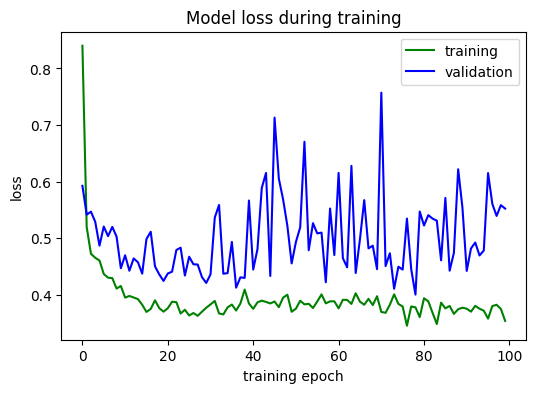

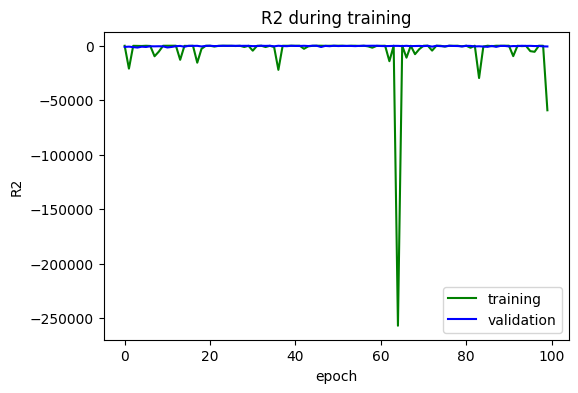

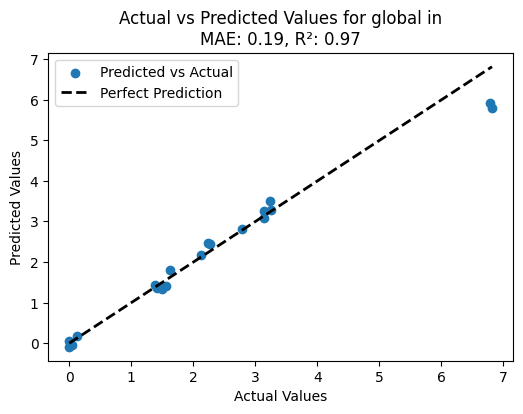

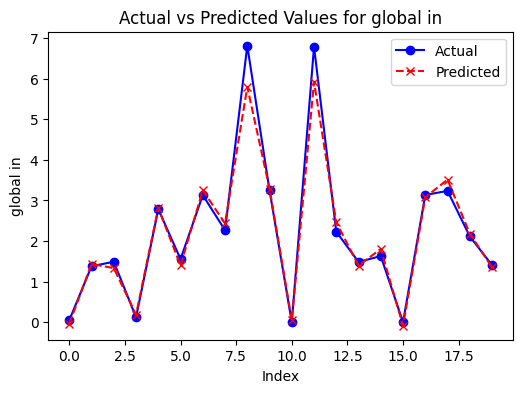

Epoch 1/100


c:\Users\frm19\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 50.9232 - mae: 3.6466 - r2_score_metric: -125.7050 - val_loss: 0.2229 - val_mae: 0.3093 - val_r2_score_metric: -2.8164
Epoch 2/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1836 - mae: 0.3021 - r2_score_metric: 0.0866 - val_loss: 0.3353 - val_mae: 0.4456 - val_r2_score_metric: -55.0172
Epoch 3/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1466 - mae: 0.2774 - r2_score_metric: 0.7747 - val_loss: 0.1929 - val_mae: 0.2767 - val_r2_score_metric: -237.1100
Epoch 4/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1298 - mae: 0.2625 - r2_score_metric: 0.8020 - val_loss: 0.1630 - val_mae: 0.2804 - val_r2_score_metric: -806.0486
Epoch 5/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1244 - mae: 0.2581 - r2_score_metric: 0.7404 - val_loss: 0.1978 - val_mae: 0.2841 - val_r2_score_metric: -32.5044
Epoch 6/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.1218 - mae: 0.2539 - r2_score_metric: 0.8067 - 

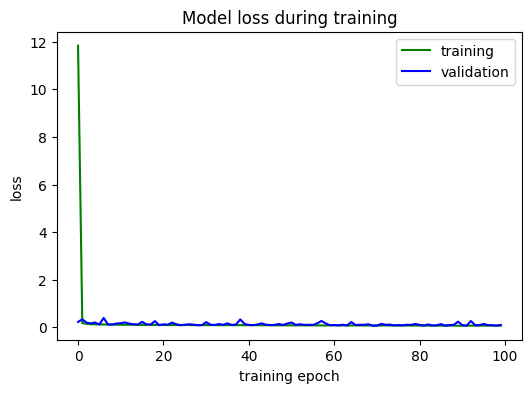

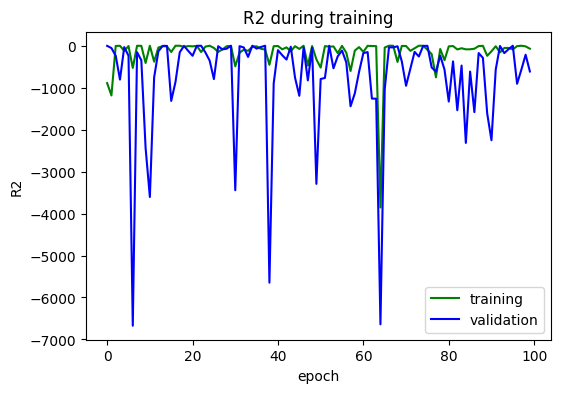

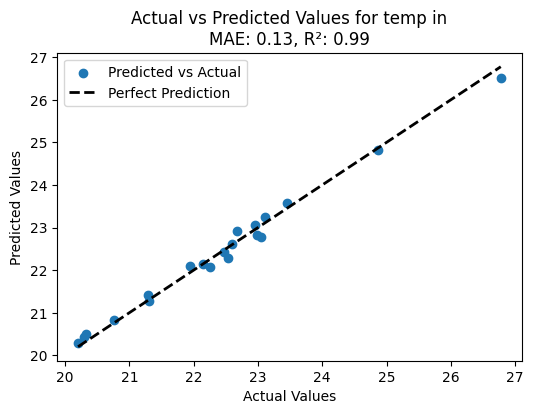

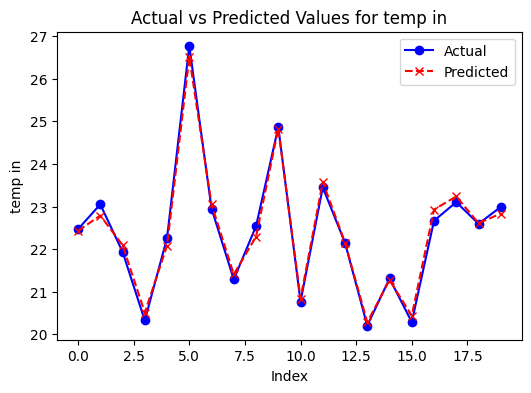

Epoch 1/100


c:\Users\frm19\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3989/3989 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 446.1987 - mae: 11.7390 - r2_score_metric: -51.4053 - val_loss: 3.8295 - val_mae: 1.2852 - val_r2_score_metric: -30305.9980
Epoch 2/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 2.5624 - mae: 1.0777 - r2_score_metric: -0.9697 - val_loss: 2.2256 - val_mae: 1.0978 - val_r2_score_metric: -2066.7046
Epoch 3/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.7808 - mae: 0.9737 - r2_score_metric: -0.1844 - val_loss: 2.5012 - val_mae: 1.2368 - val_r2_score_metric: -23242.8555
Epoch 4/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 1.7362 - mae: 0.9532 - r2_score_metric: 0.2307 - val_loss: 1.4425 - val_mae: 0.8253 - val_r2_score_metric: -404.6591
Epoch 5/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 1.6002 - mae: 0.9186 - r2_score_metric: -0.2879 - val_loss: 1.6865 - val_mae: 0.9568 - val_r2_score_metric: -3037.0176
Epoch 6/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 1.5637 - mae: 0.9052 - r2_score_met

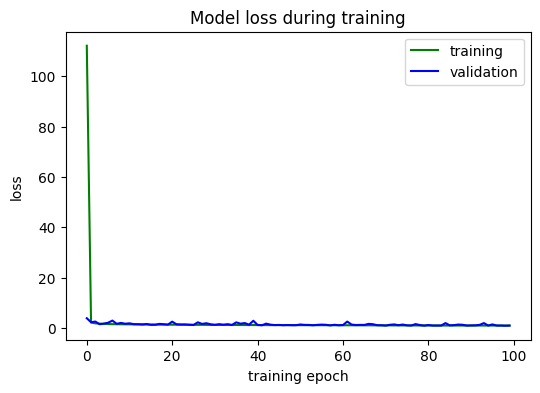

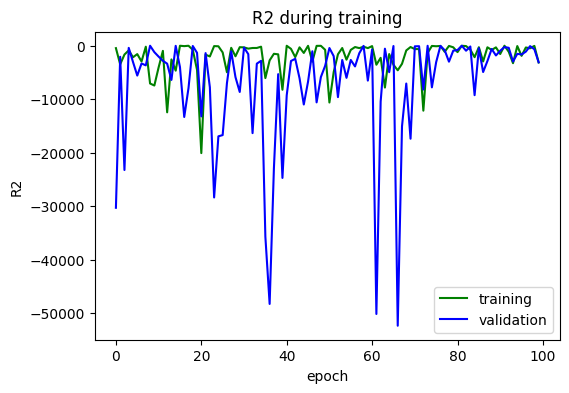

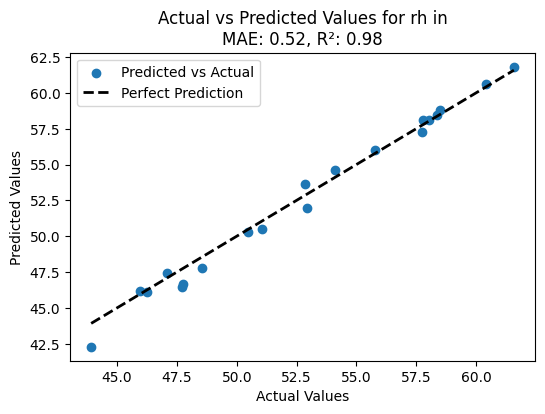

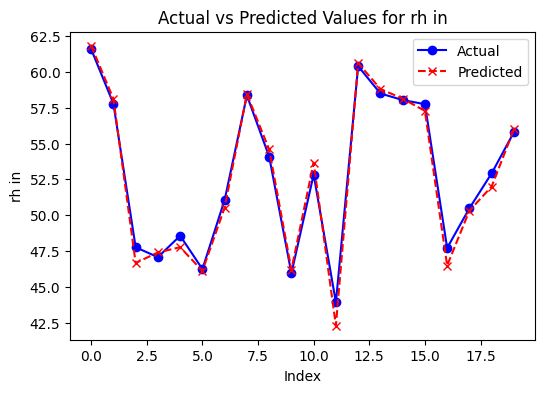

Epoch 1/100


c:\Users\frm19\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3989/3989 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 45689.7578 - mae: 142.4789 - r2_score_metric: -679458701312.0000 - val_loss: 606.1284 - val_mae: 3.9200 - val_r2_score_metric: -12280795136.0000
Epoch 2/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 338.0836 - mae: 3.4193 - r2_score_metric: -3608200448.0000 - val_loss: 590.0286 - val_mae: 3.1045 - val_r2_score_metric: -12022233088.0000
Epoch 3/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 710.9362 - mae: 3.3612 - r2_score_metric: -10484182016.0000 - val_loss: 584.2449 - val_mae: 3.3171 - val_r2_score_metric: -11883872256.0000
Epoch 4/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 339.5456 - mae: 2.7497 - r2_score_metric: -4605129216.0000 - val_loss: 579.7723 - val_mae: 3.7441 - val_r2_score_metric: -11752009728.0000
Epoch 5/100
3989/3989 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 314.4489 - mae: 2.5594 - r2_score_metric: -6037504512.0000 - val_loss: 568.0156 - val_mae: 2.9379 - val_r2_score_metric: -11585004544.

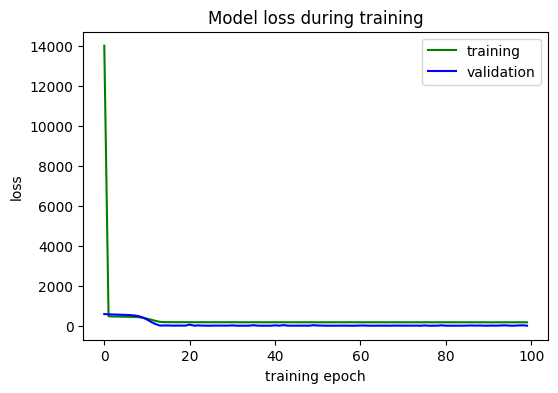

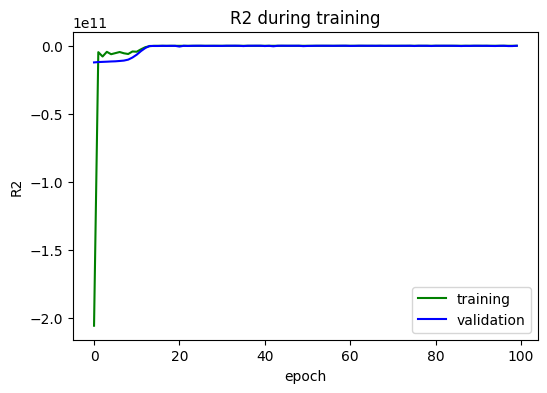

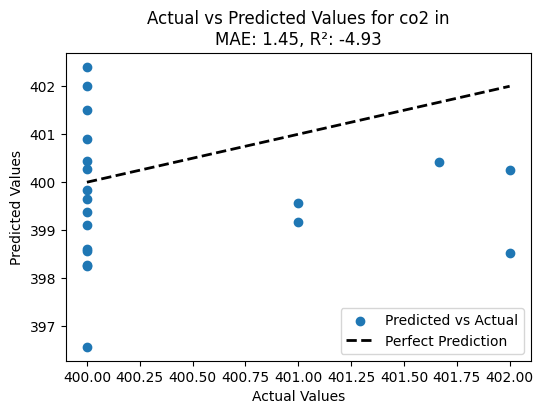

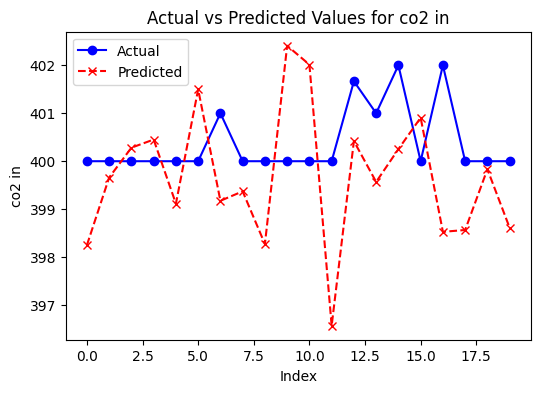

In [4]:
# List of target variables
target_variables = ['global in', 'temp in', 'rh in', 'co2 in']

# Iterate through each target variable and call the function
for target in target_variables:
    train_and_evaluate_model(target, flag_train = True, _epochs = 100, _batch_size= 4)

# Test with test datasets with trained model


In [5]:
# Load the datasets from separate files
file_path_test = r"test-iot-datasets.xlsx"

# Load and clean the test dataset
mgh_data_test = pd.read_excel(file_path_test)

# Display the first few rows of the cleaned training and test dataframes
print("\nTest Data Sample:")
print(mgh_data_test.head())

num_rows_test = len(mgh_data_test)
print(f'Number of rows test: {num_rows_test}')


Test Data Sample:
   time  global out  global in  temp in  temp out  rh in  rh out  co2 in  \
0     0    0.000000   0.000000    21.80      22.8  51.65    49.5     400   
1   300    0.029625   1.354850    22.15      22.7  51.05    49.7     400   
2   600    0.032943   1.331150    23.35      22.8  48.05    49.2     400   
3   900    0.032943   1.323250    24.15      23.0  46.05    48.6     400   
4  1200    0.010981   0.439635    24.60      23.0  44.55    48.2     400   

   co2 out  ventilation  toplights  heater  
0      613            0          1       1  
1      619            0          1       1  
2      623            0          1       1  
3      618            0          0       1  
4      602            0          0       1  
Number of rows test: 60


In [8]:
def r2_score_metric(y_true, y_pred):
    """Custom R2 score metric"""
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res/(SS_tot + tf.keras.backend.epsilon()))

def test_model(target_variable):
    features = ['time', 'global out', 'temp out', 'rh out', 'co2 out', 'ventilation', 'toplights', 'heater']
    
    X_test = mgh_data_test[features]
    y_test = mgh_data_test[target_variable]

    # Load the model using the native Keras format
    loaded_model = load_model(f'model/{target_variable}_model.keras', custom_objects={'r2_score_metric': r2_score_metric})
    
    # Load the scaler
    scaler = joblib.load(f'model/{target_variable}_scaler.pkl')
    
    # Scale the test data
    X_test_scaled = scaler.transform(X_test)
    
    y_hat_test = loaded_model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)
    
    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")
    
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()
    
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Target Variable: global in
MAE: 3.88
R²: -2.13


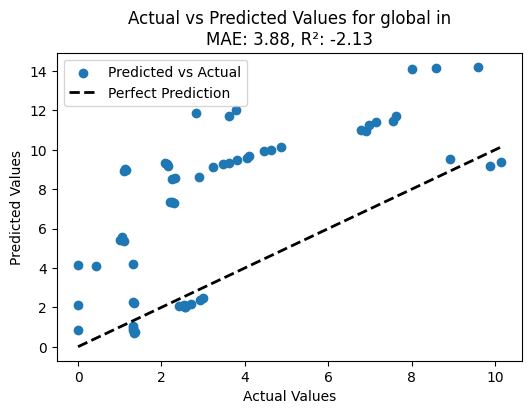

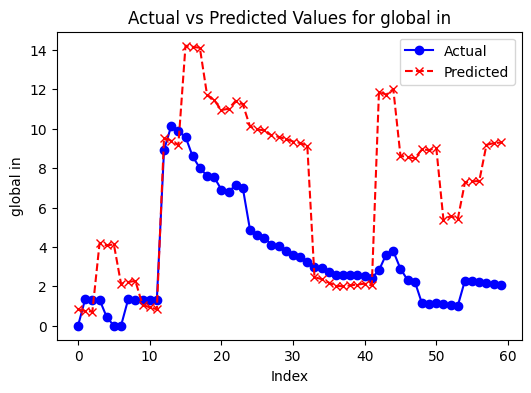

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Target Variable: temp in
MAE: 1.96
R²: 0.14


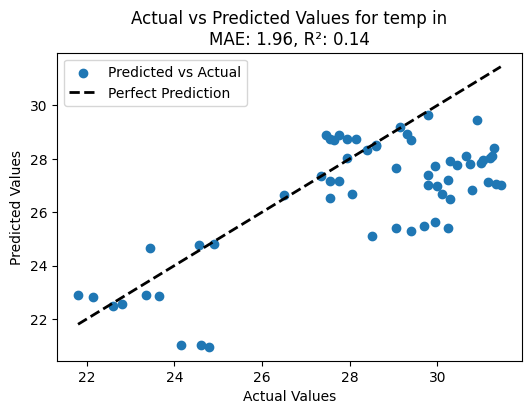

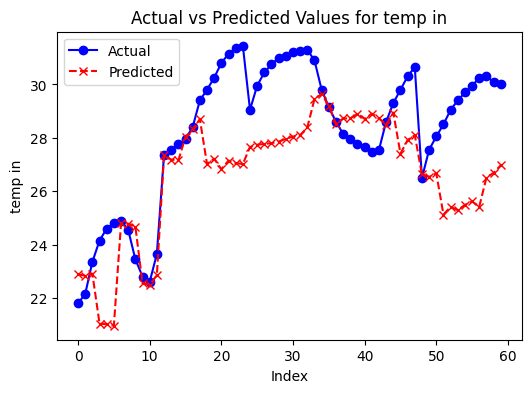

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Target Variable: rh in
MAE: 2.17
R²: 0.33


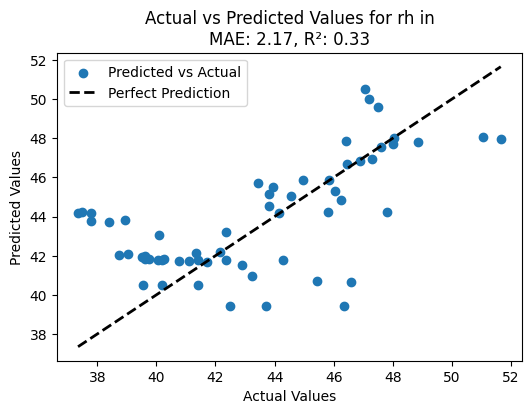

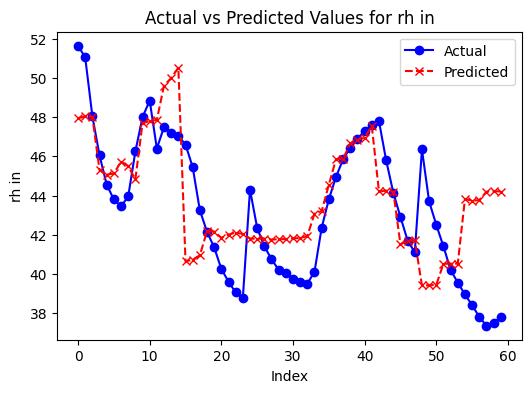

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Target Variable: co2 in
MAE: 8.74
R²: 0.00


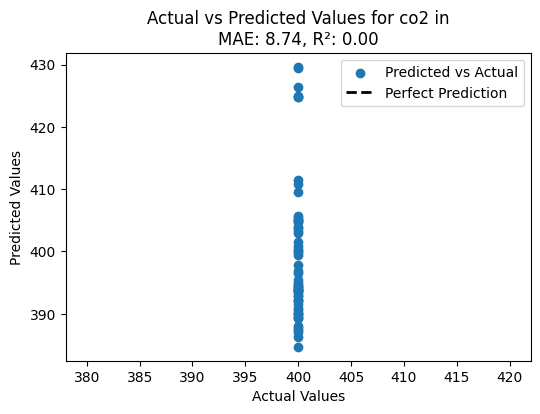

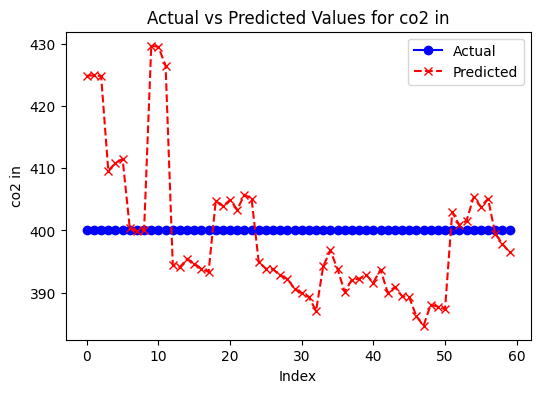

In [9]:
# List of target variables
target_variables = ['global in', 'temp in', 'rh in', 'co2 in']

# Iterate through each target variable and call the function
for target in target_variables:
    test_model(target)

# AUTOMATE THE PROCESS 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

import seaborn as sns

In [ ]:
import pandas as pd

# Load the datasets from separate files
file_path_training = r"train-iot-datasets.xlsx"
file_path_test = r"test-iot-datasets-compiled-2-converted.xlsx"

# Load and clean the training dataset
mgh_data_training = pd.read_excel(file_path_training)
#mgh_data_training = mgh_data_training.dropna()  # Drop rows with missing values

# Load and clean the test dataset
mgh_data_test = pd.read_excel(file_path_test)
#mgh_data_test = mgh_data_test.dropna()  # Drop rows with missing values

# Display the first few rows of the cleaned training and test dataframes
print("Training Data Sample:")
print(mgh_data_training.head())

print("\nTest Data Sample:")
print(mgh_data_test.head())

# Length of dataset
num_rows_training = len(mgh_data_training)
print(f'\nNumber of rows training: {num_rows_training}')

num_rows_test = len(mgh_data_test)
print(f'Number of rows test: {num_rows_test}')

# Show all rows and columns of the test dataframe
# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', None)  # Show all columns

# print("\nFull Test Data:")
# print(mgh_data_test)

# # Reset options to default
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')


In [ ]:
def train_and_evaluate_model(target_variable, _epochs=100, _batch_size=10):
    # Select features and target variable for training and test data
    features = ['time', 'global out', 'temp out', 'temp out', 'rh out', 'co2 out', 'ventilation', 'toplights', 'heater']
    
    # Training data
    X_train = mgh_data_training[features]
    y_train = mgh_data_training[target_variable]
    
    # Test data
    X_test = mgh_data_test[features]
    y_test = mgh_data_test[target_variable]

    # Normalize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build the ANN model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer for regression

    # Compile the model
    # model.compile(optimizer='adam', loss='mean_squared_error')
    model.compile(loss='mse', metrics=['mae', 'R2Score'], optimizer='rmsprop')

    # Train the model
    history = model.fit(X_train_scaled, y_train, epochs=_epochs, batch_size=_batch_size, validation_split=0.2, verbose=1)

    # Make predictions on the test set
    y_hat_test = model.predict(X_test_scaled)

    # Calculate MAE and R² score
    mae = mean_absolute_error(y_test, y_hat_test)
    r2 = r2_score(y_test, y_hat_test)
    
    # Plot loss (MSE) for both training and validation split
    plt.figure(figsize=(6, 4))
    sns.lineplot(x=history.epoch, y=history.history['loss'], color='g', label='training')
    sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='b', label='validation')
    plt.title('Model loss during training')
    plt.ylabel('loss')
    plt.xlabel('training epoch')
    plt.legend(loc='upper right')
    
    # Plot R2 for both training and validation split
    plt.figure(figsize=(6, 4))
    sns.lineplot(x=history.epoch, y=history.history['R2Score'], color='g', label='training')
    sns.lineplot(x=history.epoch, y=history.history['val_R2Score'], color='b', label='validation')

    plt.title('R2 during training')
    plt.ylabel('R2')
    plt.xlabel('epoch')
    plt.legend(loc='lower right')

    # Print MAE and R²
    print(f"\nTarget Variable: {target_variable}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.2f}")

    # Plotting the test vs predicted values
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test, y_hat_test, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target_variable}\nMAE: {mae:.2f}, R²: {r2:.2f}')
    plt.legend()
    
    # Plot the test vs predicted values in order
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_test)), y_test, marker='o', linestyle='-', color='blue', label='Actual')
    plt.plot(range(len(y_hat_test)), y_hat_test, marker='x', linestyle='--', color='red', label='Predicted')
    plt.title(f'Actual vs Predicted Values for {target_variable}')
    plt.xlabel('Index')
    plt.ylabel(target_variable)
    plt.legend()
    plt.show()

In [ ]:
# List of target variables
target_variables = ['global in', 'temp in', 'rh in', 'co2 in']

# Iterate through each target variable and call the function
for target in target_variables:
    train_and_evaluate_model(target, 200, 4)